# 2d Membrane Q4

In [1]:
Lx = 50.0
Ly = 10.0
nx = 50
ny = 10
E = 12000.0
nu = 0.2
t = 0.25
Fz = -100.0

## Define a Mesh

In [2]:
from polymesh.grid import gridQ9
import numpy as np

size = Lx, Ly
shape = nx, ny

gridparams = {"size": size, "shape": shape, "origo": (0, 0), "start": 0}

coords_, topo = gridQ9(**gridparams)
coords = np.zeros((coords_.shape[0], 3))
coords[:, :2] = coords_[:, :]

## Define a Material

In [3]:
A = np.array([[1, nu, 0], [nu, 1, 0], [0.0, 0, (1 - nu) / 2]]) * (t * E / (1 - nu**2))

## Set Boundary Conditions

In [4]:
from polymesh.utils.space import index_of_closest_point

cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True
fixity[:, 2:] = True

loads = np.zeros((coords.shape[0], fixity.shape[1]))
loadindex = index_of_closest_point(coords, np.array([Lx, Ly / 2, 0]))
loads[loadindex, 1] = Fz

## Assembly and Solution

In [5]:
from polymesh.space import StandardFrame
from sigmaepsilon.fem.mesh import FemMesh
from sigmaepsilon.fem.structure import Structure
from sigmaepsilon.fem.cells import Q9_M as Q9
from sigmaepsilon import PointData

GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame, loads=loads, fixity=fixity)
cd = Q9(topo=topo, material=A, frames=GlobalFrame.show())
meshQ4 = FemMesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=meshQ4)

structure.linear_static_analysis()
dofsol = structure.nodal_dof_solution()
structure.mesh.pointdata["x"] = coords + dofsol[:, :3]

## Triangulate and Plot

In [6]:
from polymesh.utils.topology import Q4_to_T3
from polymesh.trimesh import triangulate
from dewloosh.mpl import triplot
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl

plt.style.use("classic")

points, triangles = Q4_to_T3(structure.mesh.coords(), topo)
triobj = triangulate(points=points[:, :2], triangles=triangles)[-1]

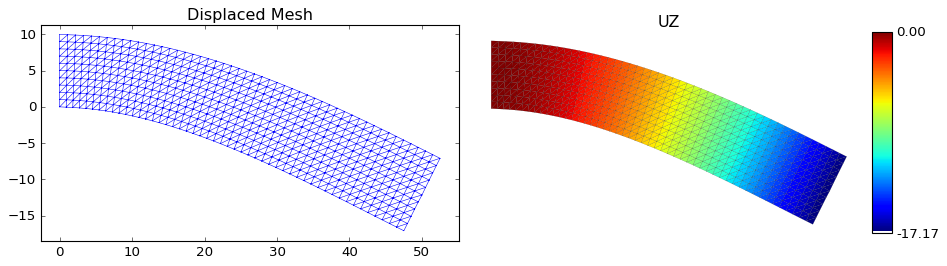

In [7]:
fig = plt.figure(figsize=(12, 6))  # in inches
fig.patch.set_facecolor("white")
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
triplot(triobj, ax=ax1, fig=fig)
triplot(triobj, ax=ax2, fig=fig, data=dofsol[:, 1], cmap="jet", axis="off")
fig.tight_layout()
ax1.set_title("Displaced Mesh")
ax2.set_title("UZ")
fig.tight_layout()